# Causal Interpretability Tutorial
This notebook walks through an end-to-end causal analysis for the implemented backdoor defense technique. We follow the DoCode (https://arxiv.org/abs/2302.03788) pipeline to:
- encode assumptions in a causal graph,
- identify the causal estimand (ATE),
- estimate the effect with a suitable backdoor method, 
- refute/validate the estimate using robustness checks, and
- report and store the results.

Goal: quantify the effect of enabling the defense (treatment) on the downstream outcome while accounting for measured confounders.

In [17]:
import pandas as pd
import numpy as np
from dowhy import CausalModel
import scipy.stats as stats
import statsmodels.api as sm
import time

# Reproducibility
np.random.seed(42)

def default_params():
    return {
    'causal_dataset': '../data/causal_analysis/causal_data.csv',
    'treatment_column': 'treatment',
    'outcome_column': 'output',
    'confounder_columns': [
        'code_number_tokens', 'code_complexity', 'code_num_identifiers',
        'code_num_strings', 'code_num_comments', 'docstring_num_lines',
        'docstring_num_words', 'docstring_num_sentences'
    ],
    'causal_results_output': '../data/causal_analysis/causal_effects.csv',
}

params = default_params()

### Load the causal dataset
The dataset should include:
- a binary treatment column (e.g., whether the defense is enabled),
- an outcome column (task performance metric), and
- a set of potential confounders (code and docstring features).

We will validate that all required columns are present.

In [18]:
causal_df = pd.read_csv(params['causal_dataset'])

In [19]:
# Validate required columns
required_cols = [params['treatment_column'], params['outcome_column'], *params['confounder_columns']]
missing_cols = sorted(set(required_cols) - set(causal_df.columns))
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")
print("[data] Loaded with required columns present.")

[data] Loaded with required columns present.


In [20]:
causal_df.head()

,index,input_code,output_docstring,code_number_tokens,code_complexity,code_num_identifiers,code_num_strings,code_num_comments,docstring_num_lines,docstring_num_words,docstring_num_sentences,output,treatment
0,37631,"def p_FuncDef(p):\n p[0] = FuncDef(p[2], p[...",FuncDef : DEF RefModifier INDENTIFIER LPARENT ...,10,1,0,0,0,1,12,0,0,0
1,172041,def reload(self):\n new_model = self.collec...,Load this object from the server again and upd...,8,1,2,0,0,1,15,1,1,0
2,107093,"def path_helper(self, path, view, **kwargs):\n...",Path helper for Flask - RESTy views .,50,3,7,7,0,1,8,1,0,0
3,165741,"def _GeneratePathString(self, mediator, pathsp...",Generates a string containing a pathspec and i...,24,2,2,2,0,1,10,1,0,0
4,76152,"def knot_insertion_kv(knotvector, u, span, r):...",Computes the knot vector of the rational / non...,53,5,2,0,0,1,16,1,0,0


## DoCode Causal Inference Framework
A concise, practical pipeline to generate causal explanations in five steps:
1. Encode causal assumptions as a graph.
2. Identify the causal estimand (e.g., Average Treatment Effect, ATE).
3. Estimate the causal effect using an appropriate method.
4. Refute the estimate with robustness checks.
5. Report results and assumptions.

### Step 1 — Encode causal assumptions in a graph
We specify treatment, outcome, and measured confounders to build the causal graph.

In [21]:
# Define causal model 
causal_model = CausalModel(
            data=causal_df,
            treatment=params['treatment_column'],
            outcome=params['outcome_column'],
            common_causes=params['confounder_columns'])

[graph] Causal graph rendered/saved.


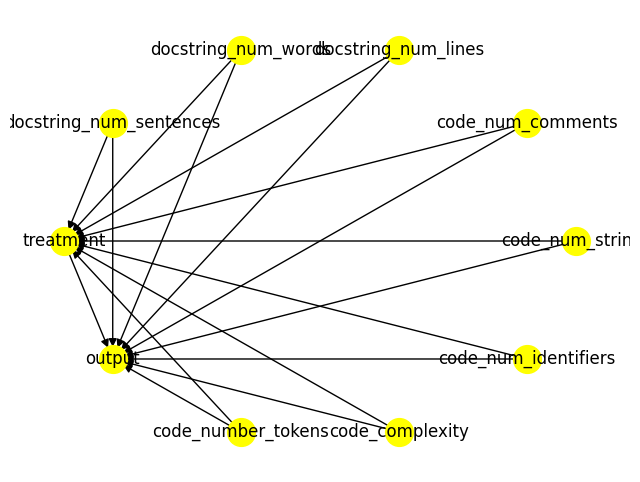

In [22]:
# Visualize the causal graph (skip gracefully if running headless)
try:
    causal_model.view_model()
    print("[graph] Causal graph rendered/saved.")
except Exception as e:
    print(f"[warn] Could not visualize causal graph: {e}")

### Step 2 — Formulate the causal estimand
Define the causal quantity of interest (here: ATE) implied by the graph and assumptions.


In [23]:
# Identify estimand once
identified_causal_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
print("[estimand] Identified causal estimand:")
print(identified_causal_estimand)

[estimand] Identified causal estimand:
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ↪
────────────(E[output|docstring_num_words,code_num_identifiers,docstring_num_s ↪
d[treatment]                                                                   ↪

↪                                                                              ↪
↪ entences,code_num_comments,code_num_strings,code_complexity,docstring_num_li ↪
↪                                                                              ↪

↪                         
↪ nes,code_number_tokens])
↪                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→output then P(output|treatment,docstring_num_words,code_num_identifiers,docstring_num_sentences,code_num_comments,code_num_strings,code_complexity,docstring_num_lines,code_number_tokens,U) = P(output|treatment,docstring_num_words,co

### Step 3 & 4
#### Step 3 — Estimate the causal effect
DoWhy offers multiple backdoor estimators (e.g., propensity score matching, stratification, weighting, GLM). Here we use `backdoor.propensity_score_matching` because the treatment is binary.

If the treatment had more than two levels, methods such as generalized linear models would be appropriate (see DoWhy docs). https://github.com/py-why/dowhy 

#### Step 4 — Refute and validate
We assess robustness with several refuters:
- Placebo treatment (permute treatment)
- Add unobserved common cause
- Data subset refuter
- Random common cause
These help detect sensitivity to hidden assumptions and sampling variability.


In [24]:
def compute_correlations(treatment, outcome):
    print("[corr] Computing correlations ...")
    # Coerce to Series and align, drop missing
    t = pd.Series(treatment)
    y = pd.Series(outcome)
    df = pd.DataFrame({'t': t, 'y': y}).dropna()
    if len(df) < 2:
        print("[corr] Not enough data to compute correlations.")
        return {'pearson_corr': None, 'spearman_corr': None, 'kendall_corr': None}

    try:
        # Try numeric correlations (covers binary and continuous cases)
        t_num = pd.to_numeric(df['t'], errors='coerce')
        y_num = pd.to_numeric(df['y'], errors='coerce')
        if not t_num.isna().any() and not y_num.isna().any():
            pearson_corr = stats.pearsonr(t_num, y_num).statistic
            spearman_corr = stats.spearmanr(t_num, y_num).statistic
            kendall_corr = stats.kendalltau(t_num, y_num).statistic
            print(f"[corr] pearson={pearson_corr:.4f} spearman={spearman_corr:.4f} kendall={kendall_corr:.4f}")
            return {
                'pearson_corr': pearson_corr,
                'spearman_corr': spearman_corr,
                'kendall_corr': kendall_corr
            }

        # If treatment is categorical, one-hot encode it and compute per-class Pearson vs numeric outcome
        one_hot = pd.get_dummies(df['t'])
        y_numeric = y_num if not y_num.isna().any() else pd.to_numeric(df['y'], errors='coerce')
        pearson_corrs = {col: stats.pearsonr(one_hot[col], y_numeric).statistic for col in one_hot.columns}
        print(f"[corr] categorical pearson per class: {pearson_corrs}")
        return {'pearson_corr': pearson_corrs, 'spearman_corr': None, 'kendall_corr': None}
    except Exception as e:
        print(f"[warn] Correlation computation failed: {e}")
        return {'pearson_corr': None, 'spearman_corr': None, 'kendall_corr': None}


In [25]:
def compute_ATEs_and_refute(causal_model, identified_estimand, method_name, method_params=None):
    method_params = method_params or {}
    def serialize_refutation(r):
        if r is None:
            return None
        return {
            'refutation_type': getattr(r, 'refutation_type', None),
            'old_effect': getattr(r, 'old_effect', None),
            'new_effect': getattr(r, 'new_effect', None),
            'p_value': getattr(r, 'p_value', getattr(r, 'significance', None)),
            'repr': str(r)
        }

    start = time.time()
    print(f"[estimate] Method='{method_name}' | params={method_params}")
    try:
        estimate = causal_model.estimate_effect(
            identified_estimand,
            method_name,
            method_params=method_params,
            test_significance=False
        )
        est_value = getattr(estimate, 'value', None)
        print(f"[estimate] Method='{method_name}' | effect={est_value} | elapsed={time.time()-start:.3f}s")
    except Exception as e:
        print(f"[error] Estimating effect failed for {method_name}: {e}")
        return {
            'method_name': method_name,
            'estimated_effect': None,
            'refutation_random_common_cause': None,
            'refutation_placebo_permute': None,
            'refutation_unobserved_confounder': None,
            'refutation_subset': None,
        }

    # Perform refutations with guards
    refutation_placebo_permute = None
    refutation_unobserved_confounder = None
    refutation_subset = None
    refutation_random_common_cause = None

    try:
        refutation_placebo_permute = causal_model.refute_estimate(
            identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute"
        )
        print(f"[refute] placebo_permute done")
    except Exception as e:
        print(f"[warn] Placebo permute refutation failed: {e}")
    try:
        refutation_unobserved_confounder = causal_model.refute_estimate(
            identified_estimand, estimate, method_name="add_unobserved_common_cause"
        )
        print(f"[refute] add_unobserved_common_cause done")
    except Exception as e:
        print(f"[warn] Unobserved confounder refutation failed: {e}")
    try:
        refutation_subset = causal_model.refute_estimate(
            identified_estimand, estimate, method_name="data_subset_refuter"
        )
        print(f"[refute] data_subset_refuter done")
    except Exception as e:
        print(f"[warn] Data subset refutation failed: {e}")
    try:
        refutation_random_common_cause = causal_model.refute_estimate(
            identified_estimand, estimate, method_name="random_common_cause"
        )
        print(f"[refute] random_common_cause done")
    except Exception as e:
        print(f"[warn] Random common cause refutation failed: {e}")

    return {
        'method_name': method_name,
        'estimated_effect': est_value,
        'refutation_random_common_cause': serialize_refutation(refutation_random_common_cause),
        'refutation_placebo_permute': serialize_refutation(refutation_placebo_permute),
        'refutation_unobserved_confounder': serialize_refutation(refutation_unobserved_confounder),
        'refutation_subset': serialize_refutation(refutation_subset),
    }

In [26]:
computation_methods = [
        ("backdoor.propensity_score_matching", {}),
        #("backdoor.propensity_score_stratification", {}),
        #("backdoor.propensity_score_weighting", {}),
        #("backdoor.generalized_linear_model", {"glm_family": sm.families.Gaussian()}),
    ]

[corr] Computing correlations ...
[corr] pearson=0.2055 spearman=0.2055 kendall=0.2055
[estimate] Method='backdoor.propensity_score_matching' | params={}
propensity_score_matching


/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Ba

[estimate] Method='backdoor.propensity_score_matching' | effect=0.6006166666666667 | elapsed=6.942s


/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Ba

[refute] placebo_permute done


/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Ba

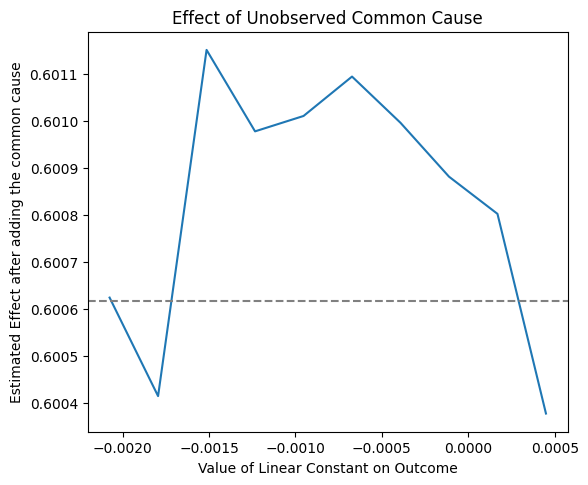

[refute] add_unobserved_common_cause done


/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Ba

[refute] data_subset_refuter done


/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Backdoor_Detect_Causal_Analysis/py310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sharwariakre/Ba

[refute] random_common_cause done
                          method_name  pearson_corr  spearman_corr  \
0  backdoor.propensity_score_matching      0.205485       0.205485   

   kendall_corr  estimated_effect  \
0      0.205485          0.600617   

                      refutation_random_common_cause  \
0  {'refutation_type': 'Refute: Add a random comm...   

                          refutation_placebo_permute  \
0  {'refutation_type': 'Refute: Use a Placebo Tre...   

                    refutation_unobserved_confounder  \
0  {'refutation_type': 'Refute: Add an Unobserved...   

                                   refutation_subset  
0  {'refutation_type': 'Refute: Use a subset of d...  


In [27]:
columns = [
    'method_name', 'pearson_corr', 'spearman_corr', 'kendall_corr',
    'estimated_effect',
    'refutation_random_common_cause', 'refutation_placebo_permute',
    'refutation_unobserved_confounder', 'refutation_subset'
]
causal_effects_df = pd.DataFrame(columns=columns)

# Compute correlations once using the public dataframe
correlation_results = compute_correlations(
    causal_df[params['treatment_column']],
    causal_df[params['outcome_column']]
)

for method_name, mparams in computation_methods:
    res = compute_ATEs_and_refute(
        causal_model, identified_causal_estimand, method_name, method_params=mparams
    )
    row = {**correlation_results, **res}
    causal_effects_df.loc[len(causal_effects_df)] = row

# Keep only rows with valid estimates
causal_effects_df = causal_effects_df.dropna(subset=['estimated_effect'])

# Preview results
print(causal_effects_df)
    

### Store the causal results
Persist the computed effects, correlations, and refutation summaries for downstream analysis and reporting.

In [28]:
causal_effects_df.to_csv(params['causal_results_output'], index=False)
print(f"[save] Causal results written to {params['causal_results_output']}")

[save] Causal results written to ../data/causal_analysis/causal_effects.csv


In [29]:
print(causal_effects_df.sort_values(by='estimated_effect', key=lambda s: s.abs(), ascending=False))

                          method_name  pearson_corr  spearman_corr  \
0  backdoor.propensity_score_matching      0.205485       0.205485   

   kendall_corr  estimated_effect  \
0      0.205485          0.600617   

                      refutation_random_common_cause  \
0  {'refutation_type': 'Refute: Add a random comm...   

                          refutation_placebo_permute  \
0  {'refutation_type': 'Refute: Use a Placebo Tre...   

                    refutation_unobserved_confounder  \
0  {'refutation_type': 'Refute: Add an Unobserved...   

                                   refutation_subset  
0  {'refutation_type': 'Refute: Use a subset of d...  
